In [ ]:
!pip install pytube
!pip install moviepy
!pip install pydub
!pip install librosa
!pip install tqdm

In [30]:
from transformers import MusicgenForConditionalGeneration, AutoProcessor
from IPython.display import Audio
from tqdm.notebook import tqdm
from pydub import AudioSegment
from pytube import YouTube
from datetime import datetime
from dotenv import load_dotenv
from scipy.io import wavfile
from scipy import signal
import nest_asyncio
import librosa
import asyncio
import random
import torch
import boto3
import os
import re

In [32]:
# Functions

def current_timestamp():
    """Returns the current timestamp formatted for readability."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def get_env_variables():
    """Fetch all necessary configurations from environment variables."""
    return {
        'DEVELOPER_KEY': os.getenv('DEVELOPER_KEY'),
        'AWS_ACCESS_KEY_ID': os.getenv('AWS_ACCESS_KEY_ID'),
        'AWS_SECRET_ACCESS_KEY': os.getenv('AWS_SECRET_ACCESS_KEY'),
        'SEARCH_CACHE_TABLE': os.getenv('SEARCH_CACHE_TABLE'),
        'RESULTS_TABLE_NAME': os.getenv('RESULTS_TABLE_NAME'),
        'SEARCH_QUERY': os.getenv('SEARCH_QUERY'),
        'MAX_RESULTS': int(os.getenv('MAX_RESULTS', 50)),
        'ORDER': os.getenv('ORDER', 'viewCount'),
        'VIDEO_DURATION': os.getenv('VIDEO_DURATION', 'medium'),
        'PUBLISHED_AFTER': os.getenv('PUBLISHED_AFTER', '2010-01-01T00:00:00Z'),
        'PUBLISHED_BEFORE': os.getenv('PUBLISHED_BEFORE', '2024-12-31T23:59:59Z'),
        'RELEVANCE_LANGUAGE': os.getenv('RELEVANCE_LANGUAGE', 'en'),
        # 'VIDEO_CATEGORY_ID': os.getenv('VIDEO_CATEGORY_ID', '10'),
        'AWS_REGION': os.getenv('AWS_REGION')  # Add AWS region to the environment variables
    }

def open_aws_dynamodb_session(options):
    """
    Configures a boto3 session using AWS credentials read from environment variable.
    Returns a boto3 DynamoDB resource configured with these credentials.
    """
    try:

        # Configure the boto3 session with the read credentials
        session = boto3.Session(
            aws_access_key_id=options['AWS_ACCESS_KEY_ID'],
            aws_secret_access_key=options['AWS_SECRET_ACCESS_KEY'],
            region_name=options['AWS_REGION']  # Specify your AWS region
        )
        dynamodb_resource = session.resource('dynamodb')
        print(f"Successfully open_aws_dynamodb_session with environment variables. at {current_timestamp()}\n")
        # Return the configured DynamoDB resource
        return dynamodb_resource

    except Exception as e:
        print(f"Error open_aws_dynamodb_session from environment variables: {e} at {current_timestamp()}\n")
        return None

def convert_duration_to_seconds(duration):
    if 'H' in duration:
        hours = int(duration.split('H')[0][2:])
    else:
        hours = 0
    if 'M' in duration:
        minutes = int(duration.split('M')[0].split('T')[-1])
    else:
        minutes = 0
    if 'S' in duration:
        seconds = int(duration.split('S')[0].split('M')[-1])
    else:
        seconds = 0
    return hours * 3600 + minutes * 60 + seconds


def retrieve_video_ids(table_name, search_term, max_duration_seconds=500, dynamodb=None):
    if dynamodb is None:
        dynamodb = boto3.resource('dynamodb')

    table = dynamodb.Table(table_name)

    response = table.scan(
        ProjectionExpression='#videoId, #title, #duration',  # Adjust 'title' and 'duration' based on your column names
        ExpressionAttributeNames={
            '#videoId': 'videoId',
            '#title': 'title',
            '#duration': 'duration'
        }
    )

    items = response.get('Items', [])

    # Filter items based on search term and duration
    filtered_items = [
        item for item in items
        if search_term.lower() in item.get('title', '').lower() and
        convert_duration_to_seconds(item.get('duration', '')) < max_duration_seconds
    ]

    # Extract video IDs from filtered items, limiting to the specified total
    video_ids = [item['videoId'] for item in filtered_items]

    return video_ids

def compare_video_ids_with_file(video_ids, file_path):
    # Read video IDs from the file
    with open(file_path, 'r') as file:
        # Iterate through each line and extract video IDs
        file_video_ids = [line.strip().split(',') for line in file]

    # Check if any line in the file exactly matches the given video IDs
    return any(set(video_ids) == set(line) for line in file_video_ids)

def write_video_ids_to_file(video_ids, file_path):
    with open(file_path, 'a') as file:
        file.write(','.join(video_ids) + '\n')

def replace_mp4_with_wav(file_name):
    return re.sub(r'\.mp4$', '.wav', file_name)

async def download_and_process_video(video_id, parent_output_folder, output_folder):
    video_url = f'https://www.youtube.com/watch?v=' + video_id

    # Create a YouTube object
    yt = YouTube(video_url)

    # Filter and select the audio stream
    audio_stream = yt.streams.filter(only_audio=True, file_extension='mp4').first()

    # Define the output path for the downloaded audio
    output_path = f'{parent_output_folder}/{output_folder}/{video_id}'

    # Download the audio stream to the specified output path
    audio_stream.download(output_path=output_path)

    # Get the list of files in the downloaded folder
    files = os.listdir(output_path)

    resulting_mp4_path = f'{output_path}.mp4'

    # Move the downloaded file to the parent folder and rename it to the video ID
    os.rename(f'{output_path}/{files[0]}' , resulting_mp4_path)

    # Remove the now-empty subfolder
    os.rmdir(output_path)

    # Load the MP4 file using Pydub
    audio = AudioSegment.from_file(resulting_mp4_path, format="mp4")

    wav_file_path = replace_mp4_with_wav(resulting_mp4_path)
    
    # Export the audio to a WAV file
    audio.export(wav_file_path, format="wav")

    # Delete .mp4 file
    os.remove(resulting_mp4_path)

async def main(video_ids, parent_output_folder):
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    output_folder = f'{search_term}_{timestamp}'
    os.makedirs(f'{parent_output_folder}/{output_folder}', exist_ok=True)

    # Create a list of tasks
    tasks = [download_and_process_video(video_id, parent_output_folder, output_folder) for video_id in video_ids]

    # Run the tasks asynchronously
    await asyncio.gather(*tasks)

def process_and_get_audio_list(audio_path, numpy_shape):
    sub_folder_list = []
    audio_list = []
    sampling_rate_list = []

    for x in os.listdir(audio_path):
        if os.path.isdir(os.path.join(audio_path, x)):
            sub_folder_list.append(x)

    print(sub_folder_list)

    for x in sub_folder_list:
        # get all the wave files
        all_files = [y for y in os.listdir(os.path.join(audio_path, x)) if '.wav' in y]

        # collect the first file from each dir
        for file in all_files:
            file_path = os.path.join(audio_path, x, file)

            # process .wav file and convert to numpy array
            audio, sampling_rate = librosa.load(file_path, sr=None)
            audio = audio[:numpy_shape]
            audio_list.append(audio)
            sampling_rate_list.append(sampling_rate)

        # show file counts
        print('count: %d : %s' % (len(all_files), x))

    return audio_list, sampling_rate_list


def generate_audio(audio_list):
    # Initialize processor and model outside the loop
    processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
    
    # generate an audio sample conditioned on a text prompt through use of the [MusicgenProcessor] to pre-process the inputs
    model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

    
    inputs = processor(
        audio=audio_list[:3],
        sampling_rate=32000,
        text=["calming instrumentals", "rhythmic relaxing music"],
        padding=True,
        return_tensors="pt",
    )


    audio_values = model.generate(
        **inputs.to(device),
        do_sample=True,
        guidance_scale=1,
        max_new_tokens=256
    )
    # post-process to remove padding from the batched audio
    audio_values = processor.batch_decode(audio_values, padding_mask=inputs.padding_mask)

    return Audio(audio_values[0], rate=32000)

In [11]:
if __name__ == "__main__":
    load_dotenv()
    options = get_env_variables()
    if options:
        table_name = options['RESULTS_TABLE_NAME']
        dynamodb = open_aws_dynamodb_session(options)
        
        if dynamodb:
            file_path = 'batched_videos_list.txt'
            search_term = 'sounds'
            max_duration_seconds = 500000
            result_limit = 3
            first_pass_check = True

            # search for a comprehensive list of video ids from dynamodb
            video_ids = retrieve_video_ids(table_name, search_term, max_duration_seconds, dynamodb)            
            for _ in range(10):  # Run the loop 20 times
                
                # if both are false the new record is unique
                if first_pass_check or compare_video_ids_with_file(video_ids, file_path):
                    if not first_pass_check:
                        print('Exact match found in records, running again')
                    first_pass_check = False

                    #randomly shuffle the list and return a limited list of video ids
                    random.shuffle(video_ids)
                    video_ids = video_ids[:result_limit]

            # save record to txt file
            write_video_ids_to_file(video_ids, file_path)
            print(f"Unique video ids: {video_ids} written to file")

Successfully open_aws_dynamodb_session with environment variables. at 2024-03-07 00:18:51

Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Exact match found in records, running again
Unique video ids: ['hngjn8rNV4k', 'KpbDgKUxUYg', 'Tg1nNHXHGcg'] written to file


In [12]:
nest_asyncio.apply()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Run the event loop
parent_output_folder = 'audio_mp4s'
await main(video_ids, parent_output_folder)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [13]:
numpy_shape = 400000

audio_list, sampling_rate_list = process_and_get_audio_list(parent_output_folder, numpy_shape)
print(audio_list)

['meditation_2024-03-06_00-50', 'music_2024-03-06_21-00', 'sounds_2024-03-07_00-18', '.ipynb_checkpoints', 'sounds_2024-03-06_23-45', 'sounds_2024-03-07_00-12']
count: 3 : meditation_2024-03-06_00-50
count: 3 : music_2024-03-06_21-00
count: 3 : sounds_2024-03-07_00-18
count: 0 : .ipynb_checkpoints
count: 3 : sounds_2024-03-06_23-45
count: 3 : sounds_2024-03-07_00-12
[array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        3.4317017e-02,  3.7796021e-02,  4.1152954e-02], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
       -5.5282593e-02, -6.4346313e-02, -7.2845459e-02], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        3.9199829e-02,  3.7475586e-02,  3.5202026e-02], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
       -3.8746643e-01, -4.1659546e-01, -4.3830872e-01], dtype=float32), array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
       -2.7770996e-03, -1.9836426e-03, -1.

In [35]:
audio_list[:2]

[array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
         3.4317017e-02,  3.7796021e-02,  4.1152954e-02], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -5.5282593e-02, -6.4346313e-02, -7.2845459e-02], dtype=float32)]

In [38]:
audio_list[-2:]

[array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -5.9509277e-04, -3.3721924e-03, -1.3946533e-02], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -7.2174072e-03, -1.1917114e-02, -1.2557983e-02], dtype=float32)]

In [27]:
audio_list[0].shape

(400000,)

In [57]:
audio_list_2_items = random.sample(audio_list, 2)
audio_list_2_items

[array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -5.9509277e-04, -3.3721924e-03, -1.3946533e-02], dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -4.7930908e-01, -4.7763062e-01, -4.7499084e-01], dtype=float32)]

In [58]:
# Set device to CPU
device = torch.device("cpu")

# Initialize processor and model outside the loop
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
# generate an audio sample conditioned on a text prompt through use of the [MusicgenProcessor] to pre-process the inputs
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")


inputs = processor(
    audio=audio_list_2_items,
    sampling_rate=32000,
    text=["calming instrumentals", "slow bpm, mindful "],
    padding=True,
    return_tensors="pt",
)

audio_values = model.generate(**inputs.to(device), do_sample=True, guidance_scale=1, max_new_tokens=128)

# post-process to remove padding from the batched audio
audio_values = processor.batch_decode(audio_values, padding_mask=inputs.padding_mask)

audio_output = Audio(audio_values[0], rate=32000)
audio_output

In [59]:
audio_values[0][0]

array([ 1.27418811e-04, -8.04716765e-05,  5.57880616e-04, ...,
        6.76995516e-03,  7.68391555e-03,  8.97165481e-03])

In [60]:
audio_values[-1]

array([[ 1.27418811e-04, -8.04716765e-05,  5.57880616e-04, ...,
         1.38351023e-01,  1.36688590e-01,  1.36938319e-01]])

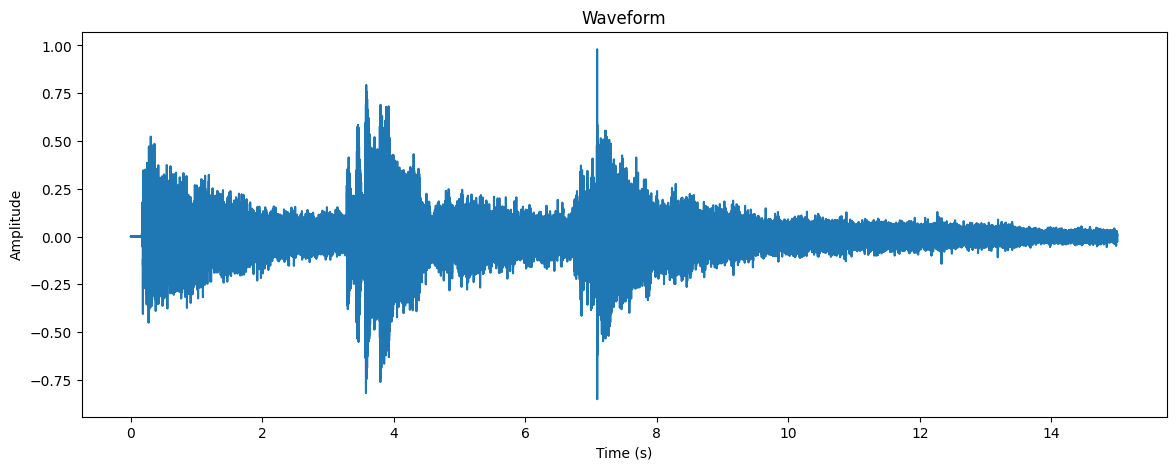

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sr' is the sample rate
sr = 32000  # Replace with your actual sample rate

# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(audio_values[0][0])) / sr, audio_values[0][0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

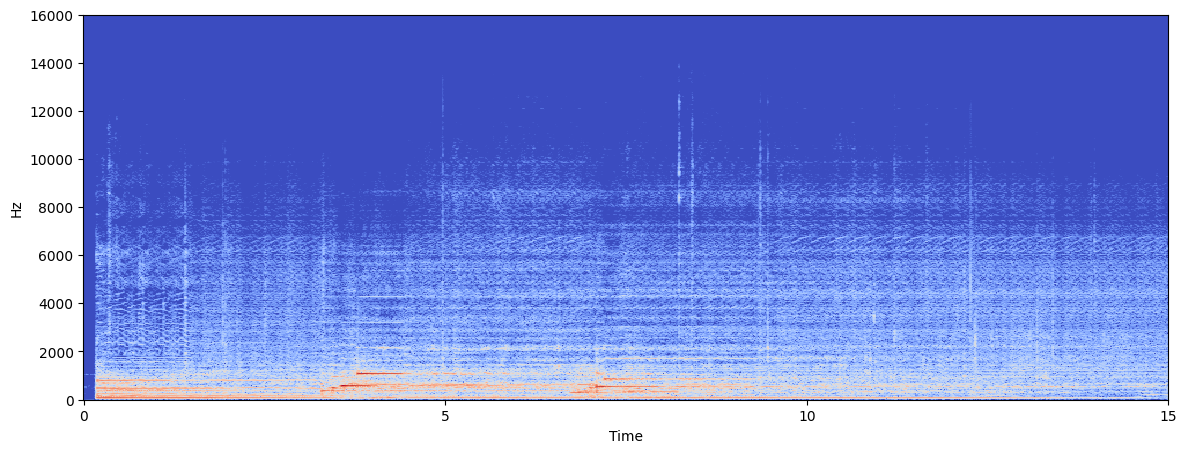

In [62]:
import matplotlib.pyplot as plt

X = librosa.stft(audio_values[0][0])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=32000, x_axis='time', y_axis='hz')